In [1]:
import copy
import random
from collections import defaultdict
from typing import Callable, Optional

import numpy as np
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm

from src.dataset import get_splits, ImageDataset
from src.utils import plot_result
from diffusion.diffusion import get_pretrained as get_diffusion

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
torch.cuda.manual_seed(12345)

In [2]:
def predict(model, x, normalize: str = "none"):
    """Returns predictions of model(x) according to the
    normalization strategy"""
    
    def apply_preprocessing(x: torch.Tensor,
                            pred: Optional[torch.Tensor] = None
                            ) -> tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Returns x processed according to `dset_config["normalize"]`.
        If pred is not None and `dset_config["normalize_output"]` is true,
        then it also returns `pred` with an inverse normalization operation.
        """

        if normalize == "standard":
            mean = torch.mean(x.reshape(x.size(0), -1), dim=1).view(x.size(0), 1, 1, 1)
            std = torch.std(x.reshape(x.size(0), -1), dim=1).view(x.size(0), 1, 1, 1)
            x = (x - mean)/std
            if pred is not None:
                pred = pred*std + mean
            return x, pred
        if normalize == "minmax":
            mi = torch.min(x.reshape(x.size(0), -1), dim=1).values.view(x.size(0), 1, 1, 1)
            ma = torch.max(x.reshape(x.size(0), -1), dim=1).values.view(x.size(0), 1, 1, 1)
            x = (x - mi)/(ma - mi)
            if pred is not None:
                pred = pred*(ma - mi) + mi
            return x, pred
        return x, pred

    x_processed, _ = apply_preprocessing(x)
    pred_processed = model(x_processed)
    _, pred = apply_preprocessing(x, pred_processed)
    return pred

In [3]:
def evaluate(model: Callable[[torch.Tensor], torch.Tensor], dataset: ImageDataset,
             im_size: int = 1024, max_val: int = 16800, batch_size: int = 8,
             normalize: str = "none", dtype: torch.dtype = torch.float) -> dict[str, float]:
    """
    Returns a dict with evaluation metrics of the `model` in the `dataset`.
    The `model` will need to be a function that takes a batch of images
    (i.e. size [batch_size, 1, 1024, 1024]) and returns the unnoised image (tensor of the
    same size).

    The `dset_config` should potentially be a dict with a "normalize" key and
    "normalize_output" key, that will indicate the dataset configuration
    used by `model` during training.
    """

    dataset = copy.deepcopy(dataset)
    dataset.default_transformation = v2.Compose([v2.ToTensor(), v2.ToDtype(torch.float32)])
    assert dataset.normalize == "none"
    loader = DataLoader(dataset, batch_size=batch_size)
    metrics = defaultdict(list)
    for sample in (pbar := tqdm(loader, desc="Evaluating")):
        x = sample["input_image"]
        y = sample["output_image"]
        assert x.size() == y.size()
        assert x.size(2) % im_size == 0
        assert x.size(3) % im_size == 0
        for i in range(0, x.size(2), im_size):
            for j in range(0, x.size(3), im_size):
                x_cropped = x[:, :, i : i+im_size, j : j+im_size]
                y_cropped = y[:, :, i : i+im_size, j : j+im_size]

                pred = predict(model, x_cropped.to(DEVICE), normalize=normalize).cpu()

                dif = (pred - y_cropped).view(batch_size, -1)
                mse = torch.mean(dif**2, dim=1)
                mae = torch.mean(torch.abs(dif), dim=1)
                psnr = torch.where(mse == 0, 100, 20*torch.log10(max_val/torch.sqrt(mse)))

                metrics["mse"] += mse.tolist()
                metrics["mae"] += mae.tolist()
                metrics["psnr"] += psnr.tolist()

                pbar.set_postfix(psnr=np.mean(metrics["psnr"]))
    return {metric: np.mean(vals) for metric, vals in metrics.items()}

In [4]:
_, dset_test = get_splits("data", normalize="none")

/home/alehc/.local/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
# Get random subsample to use in the predictions.
subsample = Subset(dset_test, random.choices(list(range(len(dset_test))), k=4))
mip = []
edof = []
for batch in subsample:
    mip.append(batch["input_image"])
    edof.append(batch["output_image"])
mip = torch.stack(mip)
edof = torch.stack(edof)
mip.shape

torch.Size([4, 1, 1024, 1024])

In [6]:
print("Evaluating identity")
evaluate(lambda x: x, dset_test)

Evaluating identity


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

{'mse': 19145.713037967682,
 'mae': 76.96297599719121,
 'psnr': 49.14588334927192}

In [7]:
print("Evaluating diffusion")
model = get_diffusion().to(DEVICE).eval().requires_grad_(False).bfloat16()
evaluate(model.predict, dset_test, normalize="minmax")

Evaluating diffusion
Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

{'mse': 4900.629321327577,
 'mae': 37.846284445661766,
 'psnr': 53.543163776397705}

In [10]:
# Get diffusion predictions.
diffusion = []
for x in tqdm(mip, desc="Predicting"):
    diffusion.append(predict(model.predict, x.unsqueeze(0).to(DEVICE), normalize="minmax").squeeze(0).cpu().float())
diffusion = torch.stack(diffusion)
diffusion.shape

Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([4, 1, 1024, 1024])

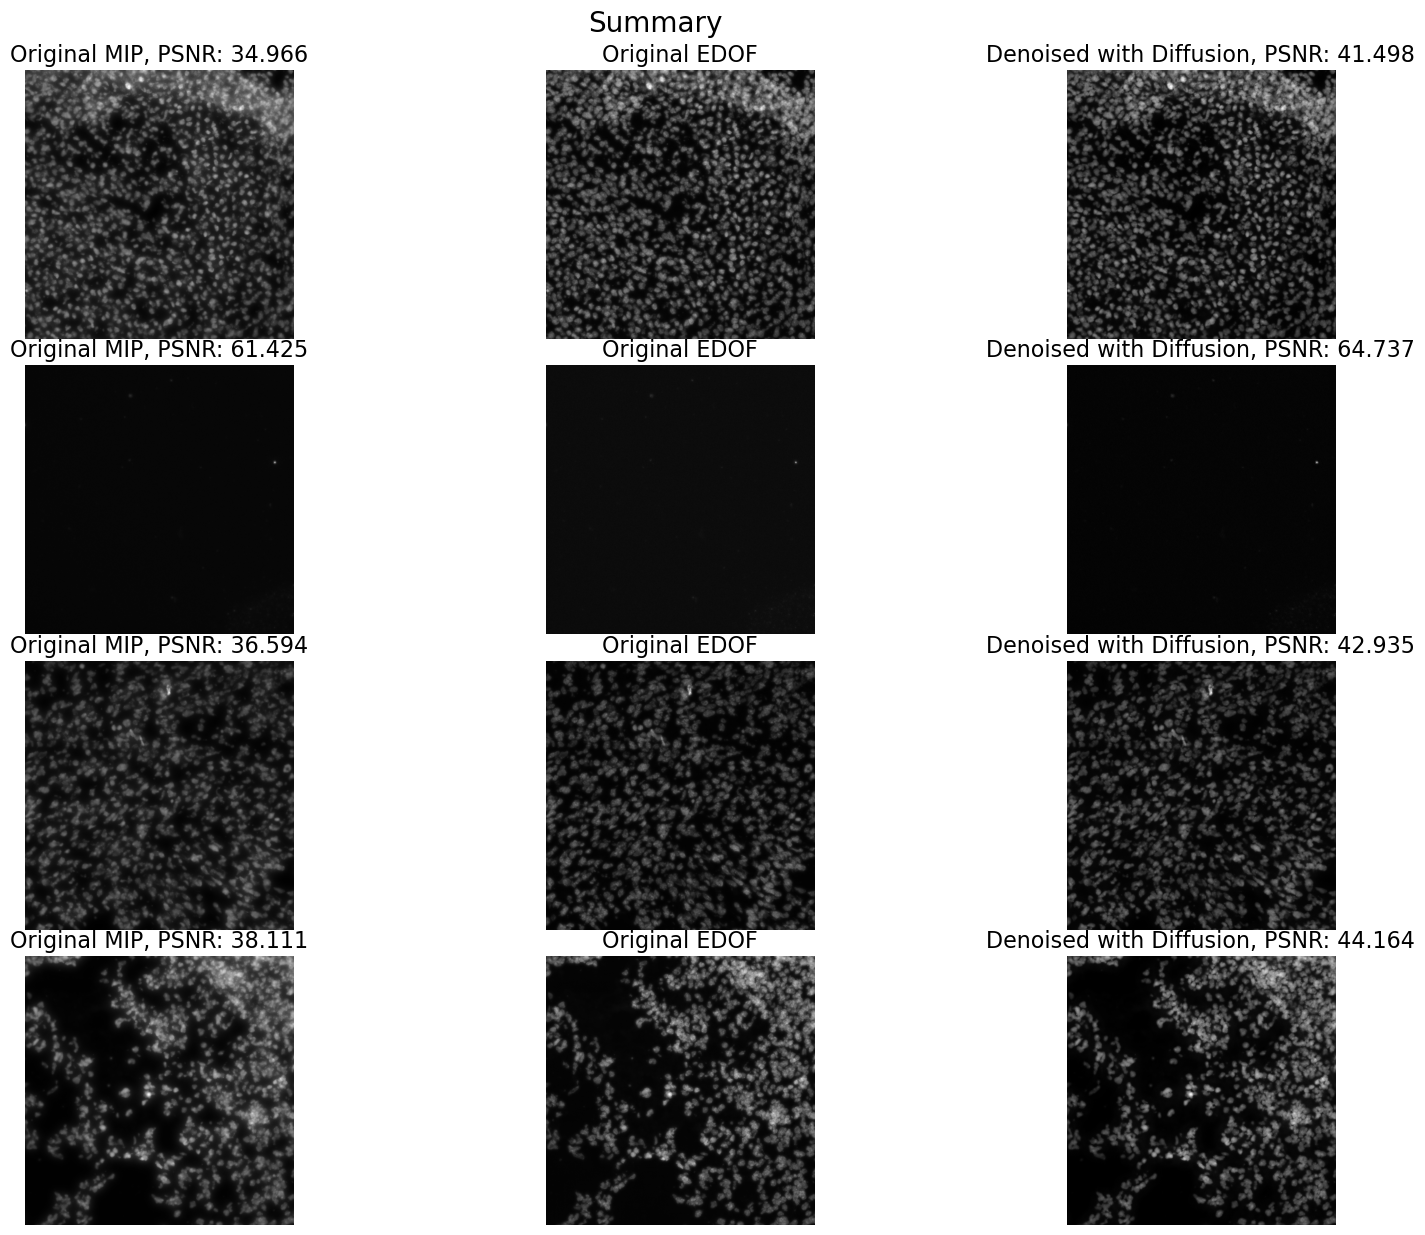

In [11]:
# Now plot everything.
results = [
    {"MIP": mip[0].numpy(), "EDOF": edof[0].numpy(), "Diffusion": diffusion[0].numpy()}
    for (mip, edof, diffusion) in zip(mip, edof, diffusion)
]
plot_result(results, "Summary")